# Imports

In [1]:
# imports
import sys
sys.path.append('..')
from functions import *
from networks import *
from plotting import *
from transforms import *
from distribution import *
from statistical import *

In [2]:
import os
# Change to the directory where the train folder is located
os.chdir('../writeup_notebooks_base')
# Verify the change
print("New Working Directory:", os.getcwd())

New Working Directory: /Users/gf244AA/Desktop/Code/fpm-paper-code/writeup_notebooks_base


In [3]:
# import matplotlib
import matplotlib.pyplot as plt

# format sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

# matplotlib params
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.direction'] = 'out' # ticks points outwards
plt.rcParams['lines.linewidth'] = 2.0 # bigger linewidth
plt.rcParams['svg.fonttype'] = 'none' # matplotlib svg text setting

# Initialize Colonies

In [4]:
# params
n_vpn = 20*90
n_kc = 25000
k = 8
p = 0.05
q_l = None # only useful if initialising weights
q_r = None # only useful if initialising weights
alpha = 0.95
mode="top"
init_weights=False
weight_mode='1'
training_mode='exp'
epsilon=0

In [5]:
# useful variables
crossover_index = {'DS_q=1':0, 'DS_q=0.9':1, 'DS_q=0.8':2, 'DS_q=0.7':3, 'DS_q=0.6':4}
overlap_index = {0:0, 8:1, 16:2, 24:3, 32:4, 40:5}

# true mode location dictionnary
mode_location_dict = {
"MODE_1A": 34.7,
"MODE_1B": 16.3,
"MODE_1C": 30.1,
"MODE_2A": 50.5,
"MODE_2B": 70.3,
"MODE_2C": 74.3,
"MODE_3A1": 25.0,
"MODE_3A2": 33.3,
"MODE_3A3": 24.7,
"MODE_3B1": 35.3,
"MODE_3B2": 75.5,
"MODE_3B3": 34.8,
"MODE_3C1": 55.4,
"MODE_3C2": 64.9,
"MODE_3C3": 43.8,
}

# tensor with performances
performance_tensor = np.zeros(shape=(15, 5, 6))
performance_vector = np.zeros(shape=(15,))

In [6]:
# dict of colonies
crossover_names = ['DS_q=1', 'DS_q=0.9', 'DS_q=0.8', 'DS_q=0.7', 'DS_q=0.6']
overlap_names = [0, 8, 16, 24, 32, 40]
colony_size = 50
colony_dict = {(crossover_names[i],overlap_names[i]):[] for i in range(5)}

# create colonies
for i, col1 in enumerate(crossover_names):
    print(col1)
    col2 = overlap_names[i]
    for j in range(colony_size):
        # initialize
        model = LRMBNetwork(
                        n_vpn, 
                        n_kc, 
                        k, 
                        p, 
                        q_l, 
                        q_r, 
                        alpha, 
                        mode, 
                        init_weights, 
                        weight_mode, 
                        training_mode,
                        epsilon)
        # load weights
        model.LeftMB.load_weights('../params_fwd/PARAMS/{}/ant_{}_L.pth'.format(col1, j))
        model.RightMB.load_weights('../params_fwd/PARAMS/{}/ant_{}_R.pth'.format(col1, j))
        # append to colony
        colony_dict[(col1, col2)].append(model)

DS_q=1
DS_q=0.9
DS_q=0.8
DS_q=0.7
DS_q=0.6


# Experiments
-------------

# Train Path 2A

In [7]:
train_path = np.load('../writeup_paths/train/path_2a.npy')[:15]
train_image = train_path[0]
FPM = compute_fpm(train_image)
FPM

0.30619019722710406

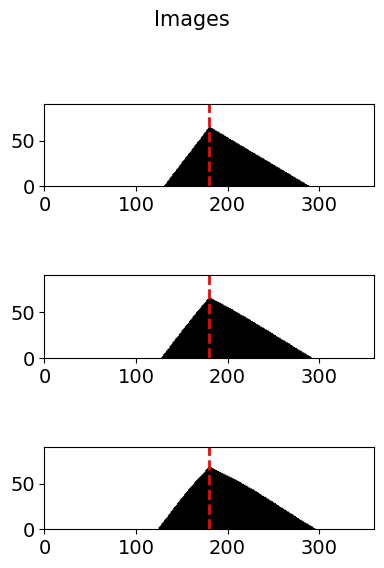

In [8]:
plot_images(train_path[::5])

In [9]:
# train all colonies on the train image
for name, colony in colony_dict.items():
    print (name)
    # transform to get down model features
    train_path_down = [overlap_downsample_transform(arr, overlap=name[1]) for arr in train_path]
    # train
    for model in colony:
        model.LeftMB.initialize_output_weights()
        model.RightMB.initialize_output_weights()
        model.train_network(train_path_down)

('DS_q=1', 0)


/Users/gf244AA/Desktop/Code/fpm-paper-code/writeup_notebooks_additional/../networks.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  image_sequence = torch.Tensor(image_sequence).unsqueeze(1)


('DS_q=0.9', 8)
('DS_q=0.8', 16)
('DS_q=0.7', 24)
('DS_q=0.6', 32)


# Test Training Image

In [10]:
# load test image
test_rotations = get_shifted_rotations(train_image)
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

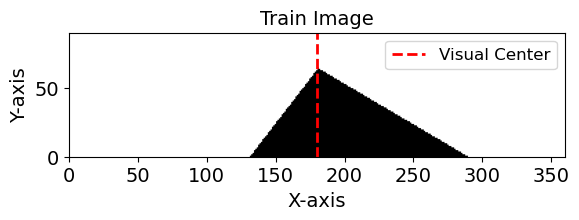

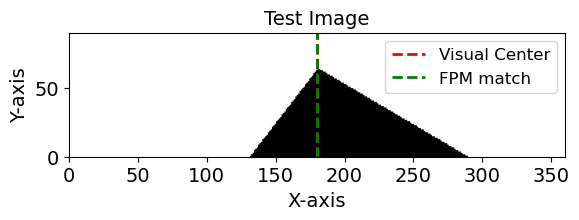

In [11]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [12]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [13]:
# loop over colonies ()params
for name, colony in colony_dict.items():
    # print colony name
    print (name)

    # get test rotations
    test_rotations_transformed = [overlap_downsample_transform(arr, overlap=name[1]) for arr in test_rotations]
    rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
    rotation_tensor = torch.stack(rotation_tensor)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[name][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[name] = left_arr
    right_dict[name] = right_arr
    sum_dict[name] = sum_arr
    diff_dict[name] = diff_arr

('DS_q=1', 0)
('DS_q=0.9', 8)
('DS_q=0.8', 16)
('DS_q=0.7', 24)
('DS_q=0.6', 32)


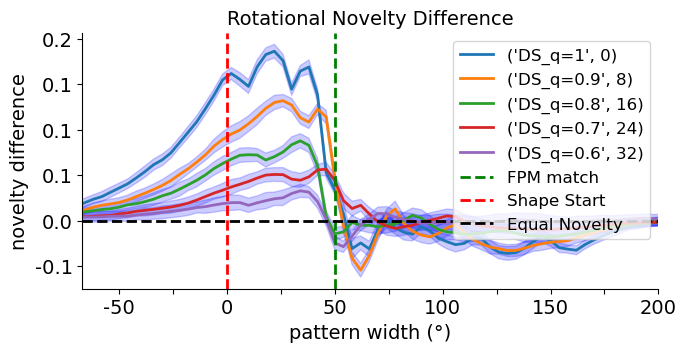

In [14]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/diff_2A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

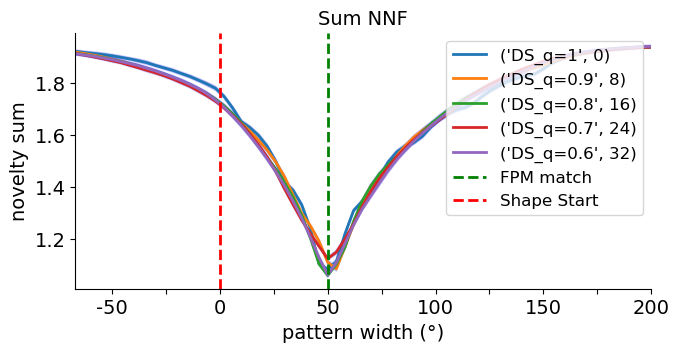

In [15]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/sum_2A.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

# Test Image 2B

In [16]:
# load test image
test_rotations = np.load('../writeup_paths/test/image_2b_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180
theoretical_angle

24

In [17]:
x_plf = np.argmax(np.sum(test_image,axis=0))
x_plf
plf_angle = x_plf - 180

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

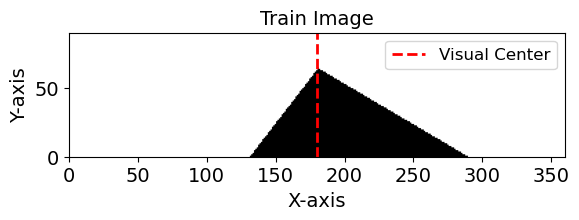

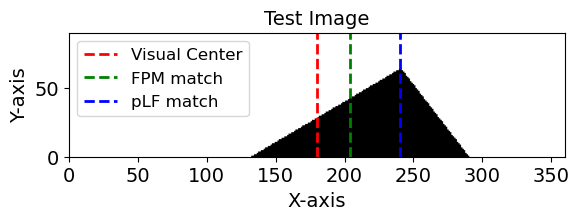

In [18]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, plf=x_plf, title='Test Image')

In [19]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [20]:
# loop over colonies ()params
for name, colony in colony_dict.items():
    # print colony name
    print (name)

    # get test rotations
    test_rotations_transformed = [overlap_downsample_transform(arr, overlap=name[1]) for arr in test_rotations]
    rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
    rotation_tensor = torch.stack(rotation_tensor)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[name][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[name] = left_arr
    right_dict[name] = right_arr
    sum_dict[name] = sum_arr
    diff_dict[name] = diff_arr

('DS_q=1', 0)
('DS_q=0.9', 8)
('DS_q=0.8', 16)
('DS_q=0.7', 24)
('DS_q=0.6', 32)


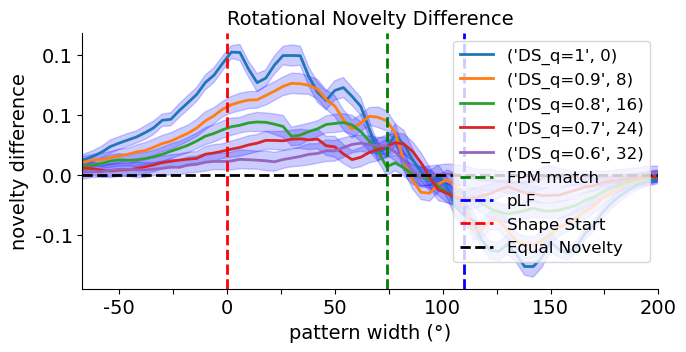

In [21]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=plf_angle+ROLL, color='blue', linestyle='--', label='pLF')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/diff_2B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

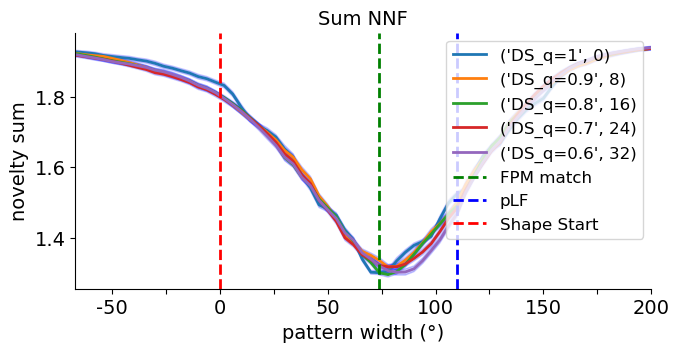

In [22]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=plf_angle+ROLL, color='blue', linestyle='--', label='pLF')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/sum_2B.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

# Test Image 2C

In [23]:
# load test image
test_rotations = np.load('../writeup_paths/test/image_2c_rotations.npy')
test_image = test_rotations[180]
x_fpm = x_from_fpm(image=test_image, fpm=FPM)
theoretical_angle =  x_fpm - 180
theoretical_angle

28

<Axes: title={'center': 'Test Image'}, xlabel='X-axis', ylabel='Y-axis'>

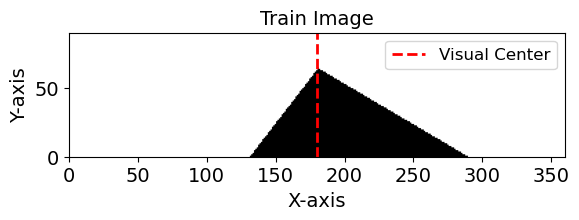

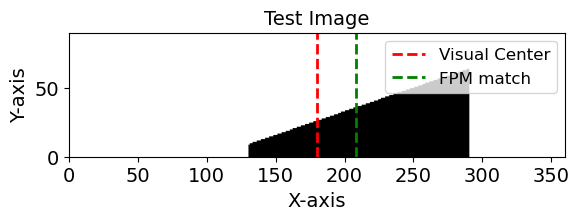

In [24]:
# Plot train and test with FPM match
plot_image(train_image, title='Train Image')
plot_image(test_image, fpm=x_fpm, title='Test Image')

In [25]:
# initialize results dictionnaries
left_dict = {}
right_dict = {}
sum_dict = {}
diff_dict = {}

In [26]:
# loop over colonies ()params
for name, colony in colony_dict.items():
    # print colony name
    print (name)

    # get test rotations
    test_rotations_transformed = [overlap_downsample_transform(arr, overlap=name[1]) for arr in test_rotations]
    rotation_tensor = [torch.tensor(a, dtype=torch.float) for a in test_rotations_transformed]
    rotation_tensor = torch.stack(rotation_tensor)

    # initialise arrays
    left_arr = np.zeros((colony_size, 360))
    right_arr = np.zeros((colony_size, 360))
    sum_arr = np.zeros((colony_size, 360))
    diff_arr = np.zeros((colony_size, 360))

    # run all models and get matrices
    for i in range(colony_size):
        model = colony_dict[name][i]
        l, r, s, d = model.forward(rotation_tensor)
        left_arr[i,:] = l.detach().numpy().flatten()
        right_arr[i,:] = r.detach().numpy().flatten()
        sum_arr[i,:] = s.detach().numpy().flatten()
        diff_arr[i,:] = d.detach().numpy().flatten()

    # set the dictionnary to the appropriate matrix
    left_dict[name] = left_arr
    right_dict[name] = right_arr
    sum_dict[name] = sum_arr
    diff_dict[name] = diff_arr

('DS_q=1', 0)
('DS_q=0.9', 8)
('DS_q=0.8', 16)
('DS_q=0.7', 24)
('DS_q=0.6', 32)


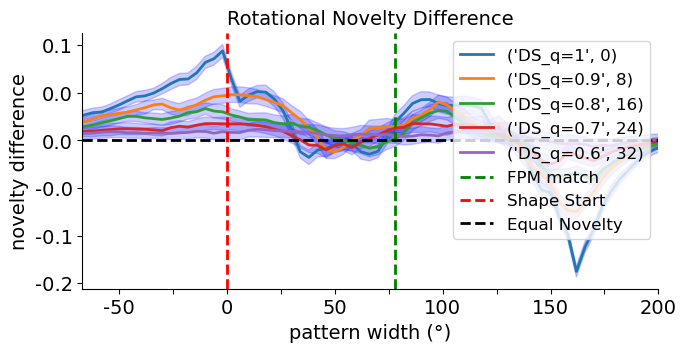

In [27]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 3

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.axhline(y=0, color='black', linestyle='--', label='Equal Novelty')
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/diff_2C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()

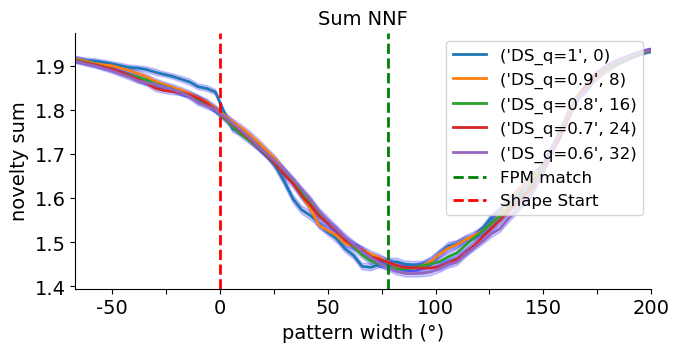

In [28]:
# Signal dictionnaries
signals = [left_dict, right_dict, sum_dict, diff_dict]

# Text information
titles = ['Left NNF', 'Right NNF', 'Sum NNF', 'Rotational Novelty Difference']
ylabels = ['novelty', 'novelty', 'novelty sum', 'novelty difference']

# Create a figure and four subplots
fig= plt.figure(figsize=(6.4, 6.4/2))

# Roll value
ROLL = 50
i = 2

# angles
angles = np.array(range(-180, 180, 1))+ROLL

# Plot the mean curves
for name in colony_dict:
    mean_curve = np.mean(signals[i][name], axis=0)
    std_curve = np.std(signals[i][name], axis=0)
    # Plot the mean curve
    plt.plot(angles[::4], (mean_curve)[::4], label=name)
    # Plot the standard deviation as a shaded region
    plt.fill_between(angles[::4], (mean_curve - std_curve)[::4], (mean_curve + std_curve)[::4], color='blue',alpha=0.2)
    
# Labelling
plt.ylabel(ylabels[i])
plt.xlabel('pattern width (°)')
plt.title(titles[i])
plt.axvline(x=theoretical_angle+ROLL, color='green', linestyle='--', label='FPM match')
plt.axvline(x=0, color='red', linestyle='--', label='Shape Start')
plt.xlim(-67, 200)  # Restrict x-axis to -90 to 90
plt.legend(loc='upper right')  # Add legend to each subplot

# Formatting
ax = plt.gca()
plt.tight_layout()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.set_position([0.1, 0.1, 0.9, 0.8])
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Define ticks from -50 to 200 in steps of 25
ticks = np.arange(-50, 225, 25)
ax.set_xticks(ticks)
# Label only every other tick
labels = [str(tick) if i % 2 == 0 else '' for i, tick in enumerate(ticks)]
ax.set_xticklabels(labels)

# Save the plot as an SVG file
plt.savefig("../writeup_exports_additional/diaghalf/sum_2C.svg", format="svg", bbox_inches='tight')

# Show the plot
plt.show()